In [1]:
#make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../../../")
import copy
from steric_free_simulator import ReactionNetwork, VectorizedRxnNet, VecSim, Optimizer, EquilibriumSolver
import networkx as nx
import torch
from torch import DoubleTensor as Tensor

EnergyExplorer Module is not available. Check Rosetta installation. <ipykernel.iostream.OutStream object at 0x7fcb087c68d0>


In [2]:
base_input = '../../input_files/tetra_one_species.pwr'
rn = ReactionNetwork(base_input, one_step=True)
rn.resolve_tree()

['default_assoc', 1.0]
['max_subunits', 4]
Using multiGraph
['A']
Parsing rule...
['A(a)+A(a)<->A(a!1).A(a!1)', 'G=-11']
['A', 'A', '']
['A(a)+A(a)', 'A(a!1).A(a!1)']
GGGGGGGGGgg
Node-1 :  (0, {'struct': <networkx.classes.multigraph.MultiGraph object at 0x7fcb046d9b70>, 'copies': tensor([200.], dtype=torch.float64)})
Node-2 :  (0, {'struct': <networkx.classes.multigraph.MultiGraph object at 0x7fcb046d9b70>, 'copies': tensor([200.], dtype=torch.float64)})
-----
{'A'}
{'A'}
set()
Steric hindrance detected
Adding another subunit
Allowed edges: 
('A', 'A')
############################3
[]
New node added--1
['A']
Adding an new edge-- 0 1
New bonds:  [('A', 'A')]
Adding an new edge-- 0 1
New node added--2
[0, 1]
Trying internal bonds
Allowed edges: 
('A', 'A')
############################3
[(1, {'struct': <networkx.classes.multigraph.MultiGraph object at 0x7fcb046d92b0>, 'copies': tensor([0.], dtype=torch.float64)})]
Node-1 :  (1, {'struct': <networkx.classes.multigraph.MultiGraph object at 

In [3]:
uid_dict = {}
sys.path.append("../../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    print(n)
    print(gtostr(rn.network.nodes[n]['struct']))
    print(rn.network.nodes[n]['struct'].edges())
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_dict[(n,k)] = uid

print(uid_dict)

0
A
[]
1
A
[('A', 'A')]
2
A
[('A', 'A'), ('A', 'A')]
3
A
[('A', 'A'), ('A', 'A'), ('A', 'A'), ('A', 'A')]
{(0, 1): 0, (0, 2): 1, (0, 3): 2, (1, 2): 1, (2, 3): 2}


In [4]:
new_kon = torch.zeros([rn._rxn_count], requires_grad=True).double()
#new_kon = [0.2244, 0.2244, 0.2255, 1.6039, 1.6039, 1.6040] # M-1 s-1   
#new_kon = [ 8995.6678,  8995.6678,  8995.6678, 10987.5746, 10987.5746, 10987.5746] #Max yield Simruntime = 10sec
#new_kon = [1.7217, 1.7216, 1.6769, 0.0990, 0.0990, 0.1352]
# new_kon =[1.0, 1.0,1.0,1.0, 1.0,1.0,1.0]*np.array([1e0])#Poor yield Simruntime = 1sec
# new_kon = [0.0162, 5.8298, 3.8969, 5.3223]
new_kon = [0.3858, 5.1422, 5.3021]

update_kon_dict = {}
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))
    update_kon_dict[edge] = new_kon[uid_dict[edge]]

nx.set_edge_attributes(rn.network,update_kon_dict,'k_on')
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))

{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-11.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-22.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-33.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-22.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-33.], dtype=torch.float64), 'uid': 2}
{'k_on': 0.3858, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-11.], dtype=torch.float64), 'uid': 0}
{'k_on': 5.1422, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-22.], dtype=torch.float64), 'uid': 1}
{'k_on': 5.3021, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-33.], dtype=torch.float64), 'uid': 2}
{'k_on': 5.1422, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-22.], dtype=torch.float64), 'uid': 1}
{'k_on': 5.3021, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-33.], dtype=torch.float64), 'uid'

In [5]:
vec_rn = VectorizedRxnNet(rn, dev='cpu')
vec_rn.reset()
# print(vec_rn.kon)
runtime = 100
sim = VecSim(vec_rn, runtime, device='cpu')
y = sim.simulate()

A
Reactant Sets:
A
Reactant Sets:
(0,)
A
Reactant Sets:
(0, 1)
A
Reactant Sets:
(0, 2)
tensor([[-2., -1., -1.,  2.,  1.,  1.],
        [ 1., -1.,  0., -1.,  1., -0.],
        [ 0.,  1., -1., -0., -1.,  1.],
        [ 0.,  0.,  1., -0., -0., -1.]], dtype=torch.float64)
tensor([0.3858, 5.1422, 5.3021], dtype=torch.float64, grad_fn=<CopySlices>)
Using CPU
Next time:  tensor(101.9544, dtype=torch.float64, grad_fn=<AddBackward0>)
Next time larger than simulation runtime. Ending simulation.


In [6]:
from torch import DoubleTensor as Tensor
import torch
M = Tensor([[-1., -2.,  0., -1.,  1.,  2., -0.,  1.],
        [-1.,  0., -1.,  0.,  1., -0.,  1., -0.],
        [ 1.,  0.,  0., -1., -1., -0., -0.,  1.],
        [ 0.,  1., -1.,  0., -0., -1.,  1., -0.],
        [ 0.,  0.,  1.,  1., -0., -0., -1., -1.]])
copies_vec = Tensor([10., 10.,  0,  0, 0])
r_filter = -1 * M.T.clone()
r_filter[r_filter == 0] = -1
nonreactant_mask = r_filter<0

#Original COde
c_temp_mat = torch.mul(r_filter, copies_vec)
# print(c_temp_mat)
l_c_temp_mat = torch.log(c_temp_mat)
l_c_temp_mat[c_temp_mat < 0] = 0
c_mask = r_filter + copies_vec
# print(r_filter)
# print(nonreactant_mask)
# print(c_mask)
l_c_temp_mat[c_mask == -1] = 0
# print(l_c_temp_mat)
l_c_prod_vec = torch.sum(l_c_temp_mat, dim=1)

#Modified code
c_temp_mat3 = torch.mul(r_filter, copies_vec)
l_c_temp_mat3 = torch.log(c_temp_mat3)
l_c_temp_mat3[nonreactant_mask]=0
l_c_prod_vec3 = torch.sum(l_c_temp_mat3, dim=1)

c_temp_mat2 = torch.pow(copies_vec,r_filter)
l_c_temp_mat2 = torch.log(c_temp_mat2)
l_c_temp_mat2[nonreactant_mask]=0
l_c_prod_vec2 = torch.sum(l_c_temp_mat2, dim=1)


# print(l_c_temp_mat)
print(l_c_prod_vec)
# print(l_c_temp_mat3)
print(l_c_prod_vec3)
# print(c_temp_mat2)
print(l_c_prod_vec2)

tensor([4.6052, 2.9957,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
       dtype=torch.float64)
tensor([4.6052, 2.9957,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
       dtype=torch.float64)
tensor([4.6052, 4.6052,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf],
       dtype=torch.float64)


In [7]:
l_k = Tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  5.0087,  5.0087, -3.7981, -3.7981])
l_rxn_rates = l_c_prod_vec2 + l_k

l_total_rate = torch.logsumexp(l_rxn_rates, dim=0)
print(l_total_rate)
l_step = 0 - l_total_rate
rate_step = torch.exp(l_rxn_rates + l_step)
print(rate_step)

a = Tensor([8.5000, 9.5000, 0.5000, 0.5000, 0.0000])
c = a < 1e-15
print(c)

delta_copies = torch.matmul(M,rate_step)
print(delta_copies)

prev_rs = Tensor([3.6358e-02, 3.8045e-05, 9.3282e-01, 3.0558e-02, 2.2310e-04, 7.1262e-06,
        6.8808e-14, 6.8808e-14])

new_delta = torch.matmul(M[1,:],prev_rs)

c = a[2]/abs(new_delta)
print(c)

tensor(5.2983, dtype=torch.float64)
tensor([0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       dtype=torch.float64)
tensor([False, False, False, False,  True])
tensor([-1.5000, -0.5000,  0.5000,  0.5000,  0.0000], dtype=torch.float64)
tensor(0.5160, dtype=torch.float64)


In [8]:
print("Done")

Done


<IPython.core.display.Javascript object>


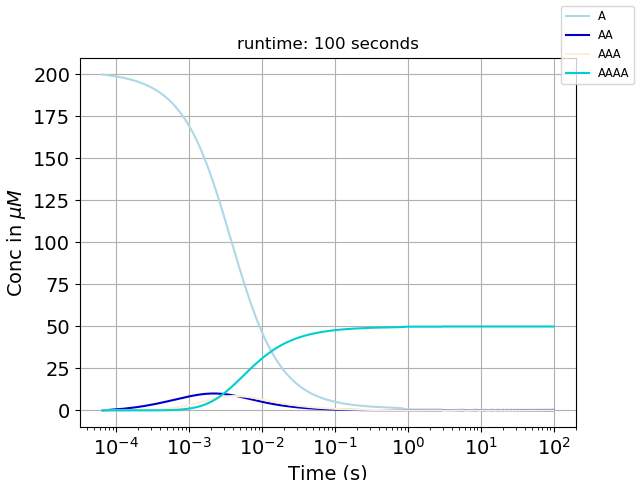

/media/Data1/adip/software/anaconda3/envs/steric_free_sim/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  


In [9]:
from matplotlib import pyplot as plt
%matplotlib notebook
fig, ax = plt.subplots()
nodes_list = ['A']
sim.plot_observable(nodes_list, ax=ax,legend=False,seed=600)
ax.set_title("runtime: " + str(runtime) + " seconds")
handles,labels = ax.get_legend_handles_labels()
fig.legend(handles,['A','AA','AAA','AAAA'],loc='best',fancybox=True,ncol=len(nodes_list),fontsize='small',markerscale=1.0)
ax.set_xscale("log")
ax.grid(which="major",axis="both")

In [10]:
print(vec_rn.copies_vec)
print(vec_rn.kon)
# print(sim.steps)

print(vec_rn.copies_vec[0] + 2*vec_rn.copies_vec[1] + 3*vec_rn.copies_vec[2])

total_conc=0
for i in range(len(vec_rn.copies_vec)):
    total_conc+=vec_rn.copies_vec[i]*(i+1)
    
print(total_conc)

tensor([ 0.0000,  0.2348,  0.0000, 49.9430], dtype=torch.float64,
       grad_fn=<MaxBackward2>)
Parameter containing:
tensor([0.3858, 5.1422, 5.3021], dtype=torch.float64, requires_grad=True)
tensor(0.4697, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(200.2415, dtype=torch.float64, grad_fn=<AddBackward0>)


In [11]:
# fig,ax = plt.subplots()
# steps = np.array(sim.steps)
# bl = (steps>0000000) & (steps<80000000)
# #abc = sim.observables[5][1].detach().tonumpy()
# print(steps[bl])
# ax.scatter(steps[bl],np.array(sim.observables[6][1])[bl])
# ax.scatter(steps[bl],np.array(sim.observables[5][1])[bl])
# ax.scatter(steps[bl],np.array(sim.observables[0][1])[bl])
# print(type(sim.steps))

In [12]:
# node_map = {}
# for node in rn.network.nodes():
#     node_map[gtostr(rn.network.nodes[node]['struct'])] = node

# print(node_map)
# def get_max_edge(n):
#     """
#     Calculates the max rate (k_on) for a given node
#     To find out the maximum flow path to the final complex starting from the current node.
    
#     Can also calculate the total rate of consumption of a node by summing up all rates. 
#     Can tell which component is used quickly.
#     """
#     try:
#         edges = rn.network.out_edges(n)
#         #Loop over all edges
#         #Get attributes
#         kon_max = -1
#         next_node = -1

#         kon_sum = 0
#         total_flux_outedges = 0
#         total_flux_inedges = 0
#         if len(edges)==0:
#             return(False)
            
#         for edge in edges:
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             #print(data)
#             #Get uid
#             uid = data['uid']

#             #Get updated kon
#             temp_kon = vec_rn.kon[uid]
#             kon_sum+=temp_kon
            
#             if temp_kon > kon_max:
#                 kon_max = temp_kon
#                 next_node=edge[1]
             
#         return(kon_max,next_node,kon_sum)
#     except Exception as err:
#         raise(err)

        
# def get_node_flux(n):
#     total_flux_outedges = 0
#     total_flux_inedges = 0
#     #Go over all the out edges
#     edges_out = rn.network.out_edges(n)
#     if len(edges_out)>0:

#         for edge in edges_out:
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             #print(data)
#             #Get uid
#             uid = data['uid']

#             #Get updated kon
#             temp_kon = vec_rn.kon[uid]

#             #Calculate k_off also
#             std_c = Tensor([1.])
#             l_kon = torch.log(temp_kon)
#             l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
#             koff = torch.exp(l_koff)

#             #Getting conc. of reactants and products
#             #Get product
#             prod = gtostr(rn.network.nodes[edge[1]]['struct']) 
#             #Get other reactant
#             react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))

#             #Net flux from this edge = Generation - consumption
#             edge_flux = koff*vec_rn.copies_vec[edge[1]] - temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])
#             #edge_flux = koff*vec_rn.copies_vec[edge[1]] 

#             print("Reaction: ", gtostr(rn.network.nodes[edge[0]]['struct']), "+",react," -> ",prod)
#             print("Net flux: ",edge_flux)
#             print("kon : ",temp_kon)
#             print("koff: ",koff)
#             print("Reaction data OUTWARD: ")
#             print(data)

#             total_flux_outedges+=edge_flux
    
#     #Now go over all the in edges
#     edges_in = rn.network.in_edges(n)
#     react_list = []
#     if len(edges_in) > 0:
#         for edge in edges_in:
#             if edge[0] in react_list:
#                 continue
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             uid = data['uid']


#             #Get generation rates; which would be kon
#             temp_kon = vec_rn.kon[uid]

#             #Get consumption rates; which is k_off
#             std_c = Tensor([1.])
#             l_kon = torch.log(temp_kon)
#             l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
#             koff = torch.exp(l_koff)

#             #Get conc. of reactants and products
#             prod = gtostr(rn.network.nodes[edge[1]]['struct'])
#             #Get other reactant
#             react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))
#             react_list.append(node_map[react])
#             #Net flux from this edge = Generation - consumption
#             edge_flux_in = temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])- koff*vec_rn.copies_vec[edge[1]]
#             #edge_flux_in = koff*vec_rn.copies_vec[edge[1]]
            


#             print("Reaction: ", prod ," -> ",gtostr(rn.network.nodes[edge[0]]['struct']), "+",react)
#             print("Net flux: ",edge_flux_in)
#             print("kon : ",temp_kon)
#             print("koff: ",koff)
#             print("Raction data INWARD: ")
#             print(data)

#             total_flux_inedges+=edge_flux_in
#     net_node_flux = total_flux_outedges + total_flux_inedges
    
#     return(net_node_flux)
    
# pathway = []
# kon_sumarray = []
# total_con_rate = {}
# net_flux = {}
# for n in rn.network.nodes():
    
#     n_str = gtostr(rn.network.nodes[n]['struct']) 
    
#     paths = [n_str]
#     kon_sum = 0
#     temp_node = n
#     max_edge = True
#     consumption_rate = 0
#     if n < len(rn.network.nodes()):#num_monomers:
# #         print("Current node: ")
# #         print(n_str)
#         while max_edge:
#             max_edge = get_max_edge(temp_node)
#             if max_edge:
#                 total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
                
#                 temp_node = max_edge[1]
#                 kon_sum += max_edge[0].item()
                
                
# #                 print("Next node: ")
# #                 print(temp_node)

#                 paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
#             else:
#                 break
#         pathway.append(paths)
#         kon_sumarray.append(kon_sum)
#         paths=[]
#     print("-------------------------------------------------------------------------------")
#     print("-------------------------------------------------------------------------------")
#     print("|                                                                             |")
#     node_flux = get_node_flux(n)
#     net_flux[gtostr(rn.network.nodes[n]['struct'])] = node_flux
#     print("|                                                                             |")
#     print("-------------------------------------------------------------------------------")
#     print("-------------------------------------------------------------------------------")

# print(pathway)
# print(kon_sumarray)

# #print(total_con_rate)

In [13]:
# for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
#     print(k," : ", v)

# print(vec_rn.copies_vec)
# print(vec_rn.kon)

In [14]:
print(vec_rn.copies_vec[1] + vec_rn.copies_vec[2] + vec_rn.copies_vec[4])

IndexError: index 4 is out of bounds for dimension 0 with size 4

In [ ]:
import networkx as nx
fig,ax = plt.subplots(figsize=(6,6))
labels = nx.get_node_attributes(rn.network, 'struct')
labels2 = ["A","B","AB","AA","AAB"]
labels = {key:labels2[key] for key in labels.keys()}

pl_pos = nx.planar_layout(rn.network)

new_kon = [0.0162, 5.8298, 3.8969, 5.3223]
edge_widths = []
edge_colors= []
for edge,uid in uid_dict.items():
    edge_widths.append(new_kon[uid])
    
nx.draw_networkx(rn.network,pos=pl_pos,labels=labels,node_size=1000,node_color='skyblue',ax=ax,edgelist=[])

nx.draw_networkx_edges(rn.network,pos=pl_pos,width=edge_widths,label=edge_widths,arrowsize=10,min_target_margin=15.0)


In [ ]:
nodes_list = ["AB"]
stoic_ratio = vec_rn.initial_copies[0].item()/vec_rn.initial_copies[1].item()
file_out = "AAB_conc_" + str(stoic_ratio) + ".out"


with open(file_out,"w") as fl1:
    data = np.array(sim.observables[4][1])
    fl1.write("time\taab\n")
    for i in range(len(data)):
        fl1.write(str(sim.steps[i]))
        fl1.write("\t")
        fl1.write(str(data[i]))
        fl1.write("\n")